# Basic CNN for traffic sign recognition
## ADL 2022

This notebook provides a template for a small CNN for the German Traffic Sign Recognition Benchmark. The data is described in:

Johannes Stallkamp, Marc Schlipsing, Jan Salmen, and Christian Igel. Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition. *Neural Networks* **32**, pp. 323-332, 2012

This notebook is a template, without modification the model does not even come close to the state-of-the-art. 

Please [contact Stefan](mailto:sommer@di.ku.dk) if you have suggestions for improving the notebook.

The original version of the notebook was written by [Christian Igel](mailto:igel@di.ku.dk). It has been slightly modified by [Stefan Sommer](mailto:sommer@di.ku.dk) and the TAs of ADL 2022.

Do the imports first:

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torchvision.datasets.utils import download_url, extract_archive

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
# Load the TensorBoard notebook extension
# %load_ext tensorboard

ModuleNotFoundError: No module named 'matplotlib'

Check if a GPU is available:

In [2]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cuda:0


The GTSRB data wrapped in a `Dataset`:

In [3]:
class GTSRBTrafficSigns(Dataset):
  def __init__(self, root = './', url = 'https://sid.erda.dk/share_redirect/EB0rrpZwuI', filename='EB0rrpZwuI.zip', train=True, force_download=False): 
    self.img_height  = 32  
    self.img_width   = self.img_height
    self.img_height_crop = 28  
    self.img_width_crop  = self.img_height_crop

    self.train = train
    archive = os.path.join(root, filename)

    if self.train:
      self.data_folder = os.path.join(root, 'GTSRB/train')
    else:
      self.data_folder = os.path.join(root, 'GTSRB/test')

    if (not os.path.exists(self.data_folder)) or force_download:
       download_url(url, root, filename)
       extract_archive(archive, root, False)
    else:
      print('Using existing', self.data_folder)

    self.dataset_train = datasets.ImageFolder(self.data_folder)

  def __getitem__(self, index):
      image, label = self.dataset_train.__getitem__(index)
      image = transforms.Resize((self.img_width,self.img_height))(image)
      
      if self.train:
        image = transforms.RandomAffine((-5,5))(image)
        image = transforms.RandomCrop((self.img_width_crop, self.img_height_crop))(image)
        image = transforms.ColorJitter(0.8, contrast = 0.4)(image)
        if label in [11, 12, 13, 17, 18, 26, 30, 35]:
          image = transforms.RandomHorizontalFlip(p=0.5)(image)
        # image = transforms.RandomPerspective(distortion_scale=0.4, p=0.3)(image)
      else:
        image = transforms.CenterCrop((self.img_width_crop, self.img_height_crop))(image)

      image = transforms.ToTensor()(image)

      return image, label

  def __len__(self):
      return self.dataset_train.__len__()

In [4]:
dataset_train = GTSRBTrafficSigns()
dataset_test = GTSRBTrafficSigns(train = False)

Using existing ./GTSRB/train
Using existing ./GTSRB/test


Define the data loader for training:

In [5]:
batch_size = 128
# generator_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2,drop_last = True)
criterion = nn.CrossEntropyLoss()


Let's visualize some input images. This visualization is very important, among others to verify that the data augmentation works as expected.

In [6]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# # get some random training images
# dataiter = iter(generator_train)
# images, labels = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images))

Let's look at some images in the batch with their label:

In [7]:
# for i in range(20,1030,30):
#   if labels[i].item() == 13:
#     imshow(images[i])
#     print(labels[i].item(), "\n\n")


To implement:

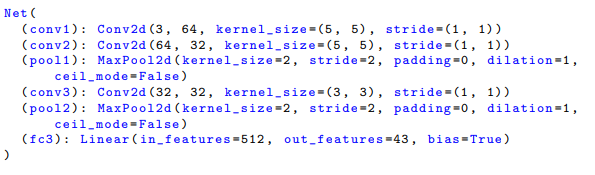

Define the neural network:

In [8]:
class Net(nn.Module):
    def __init__(self, img_size=28,batch_norm = True):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(5,5), stride=(1,1))
        # self.batchnorm1 = nn.BatchNorm2d(64, affine=False)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=(5,5), stride=(1,1))
        if batch_norm:
          self.batchnorm2 = nn.BatchNorm2d(32, affine=False)
        else:
          self.batchnorm2 = lambda x: x
        self.pool1 = nn.MaxPool2d(2,stride = 2,padding = 0, dilation = 1, ceil_mode = False)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=(1,1))
        if batch_norm:
          self.batchnorm3 = nn.BatchNorm2d(32, affine=False)
        else:
          self.batchnorm3 = lambda x: x

        self.pool2 = nn.MaxPool2d(2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)
        self.fc3   = nn.Linear(512, 53, bias = True) 

    def forward(self, x):
        # Reshape?
        x = F.elu(self.conv1(x))
        x = F.elu(self.batchnorm2(self.conv2(x)))
        x = self.pool1(x)
        x = F.elu(self.batchnorm3(self.conv3(x)))
        x = self.pool2(x)
        x = x.view(-1,512)
        x = self.fc3(x)

        # Reshape?
        return x

# net = Net()


Instantiate the neural network and potentially move it to GPU:

Define loss and optimization algorithm:

In [9]:
## switch optimizer
# optimizer = optim.Adam(net.parameters(), lr=0.01, eps=0.1)
# optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.01)

These lines can be used to continue training:

Do the training:

In [10]:


def run_training(optimizer, net,no_epochs = 200):
  
  dataset_train = GTSRBTrafficSigns()
  generator_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2,drop_last = True)

  dataset_test = GTSRBTrafficSigns(train=False)
  generator_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=2)
  net.train()

  losses = []
  test_acc = []
  for epoch in range(no_epochs):  # Loop over the dataset multiple times
      epoch_loss = running_loss = 0.0
      for i, data in enumerate(generator_train, 0):
          # Get the inputs; data is a list of [inputs, labels]
          if (gpu):
            inputs, labels = data[0].to(device), data[1].to(device)
          else:
            inputs, labels = data
          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # Print statistics



          reporting_interval = 100
          epoch_loss += loss.item()
          running_loss += loss.item()
          if i % reporting_interval == reporting_interval-1:  # Print every reporting_interval mini-batches
              # report_loss = running_loss / reproint

              test_dat = next(iter(generator_test))
              if (gpu):
                test_images, test_labels = test_dat[0].to(device), test_dat[1].to(device)
              else:
                test_images, test_labels = test_dat
              outputs = net(test_images)


              if epoch + 1 == 30:
                generator_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=2)

              _, predicted = torch.max(outputs.data, 1)

              a = (predicted == test_labels).sum().item()/test_labels.shape[0]
              l = running_loss / reporting_interval
              print('[%d, %5d] Loss: %.3f Acc: %.3f' %
                    (epoch + 1, i + 1, l, a))
              
              test_acc.append(a)
              losses.append(l)
              running_loss = 0.0

      
      # Log to tensorboard
      # writer.add_scalar("Loss/train", epoch_loss/(i+1.), epoch)


  print('Finished Training')
  writer.flush()

  return losses, test_acc


# run_training(optimizer, net, 200)

Evaluate on test set:

In [11]:
def evaluate(net):
  net.eval()
  dataset_test = GTSRBTrafficSigns(train=False)
  generator_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=2)

  correct = 0
  total = 0

  wrongs = []
  alls = []
  with torch.no_grad():
      for data in generator_test:
          if (gpu):
            images, labels = data[0].to(device), data[1].to(device)
          else:
            images, labels = data
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          wrong = labels[predicted != labels]
          wrongs.append(wrong.cpu().numpy())
          alls.append(labels.cpu().numpy())
  print('Accuracy of the network on test images: %.2f %%' % (100 * correct / total))
  return (100 * correct / total), wrongs, alls

# acc, wrongs, alls = evaluate(net)

Save network:

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
runtypes = ["Batch normalization - ADAM", "Batch normalization - SGD", "Normal - ADAM", "Normal - SGD"]

def get_n_runs(runtype):
  if not runtype in runtypes:
    print("Runtype not found")
    return 0
  if runtype == "Batch normalization - ADAM": # 3x200
    return 3
  if runtype == "Batch normalization - SGD": # 200
    return 0
  if runtype == "Normal - ADAM": # 3x200
    return 3
  if runtype == "Normal - SGD": # 200
    return 1

LR = 0.0003
def get_optimizer_and_net(runtype):
  if not runtype in runtypes:
    print("Runtype not found")
    return 
  if runtype == "Batch normalization - ADAM": # 3x200
    net = Net(batch_norm = True)
    optimizer = optim.Adam(net.parameters(), lr=LR, eps=0.1)
  if runtype == "Batch normalization - SGD": # 200
    net = Net(batch_norm = True)
    optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)
  if runtype == "Normal - ADAM": # 3x200
    net = Net(batch_norm = False)
    optimizer = optim.Adam(net.parameters(), lr=LR, eps=0.1)
  if runtype == "Normal - SGD": # 200
    net = Net(batch_norm = False)
    optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)

  return (optimizer, net)
  
pth = "/content/gdrive/MyDrive/ADL/"

def plot_loss_and_acc(loss, acc, title,runtype):
  fig, ax1 = plt.subplots()

  print(loss.shape,acc.shape)

  b, g = "royalblue", "seagreen"
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss', color = b)
  # ax1.plot(loss, label = "Loss", color = b)
  ax1.fill_between([i for i in range(len(loss[0]))], np.min(loss,axis = 0), np.max(loss,axis = 0), color = b, alpha = 0.6)
  ax1.tick_params(axis='y')
  ax1.set_ylim(0,3)
  ax1.plot(np.mean(loss,axis = 0), '--', color = b)


  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x--axis

  ax2.set_ylabel('Validation accuracy', color = g)
  # ax2.plot(acc, label = "Accuracy", color = g)
  ax2.fill_between([i for i in range(len(acc[0]))], np.min(acc,axis = 0), np.max(acc,axis = 0), color = g, alpha = 0.6)
  ax2.set_ylim(0.5,1)
  ax2.plot(np.mean(acc,axis = 0), '--', color = g)
  ax2.tick_params(axis='y')

  plt.title(title)
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  # fig.legend(loc = 0)
  
  plt.savefig(pth+runtype+str(len(acc[0]))+"epochs.png")
  plt.show()

def run_many(n_epochs = 200):
  for runtype in runtypes:
    losses, accuracies, final_accuracies = [], [], []

    N = get_n_runs(runtype)

    for i in range(N):
      optimizer, net = get_optimizer_and_net(runtype)
      if(gpu):
        net.to(device)
      loss, accs = run_training(optimizer, net, n_epochs)
      acc, wrongs, all = evaluate(net)
      
      losses.append(np.array(loss))
      accuracies.append(np.array(accs))
      final_accuracies.append(acc)
      np.savetxt(pth+ "run"+str(i) + "losses"+ runtype +str(n_epochs) + "epochs.csv", np.array(loss), delimiter = ',')
      np.savetxt(pth+ "run"+str(i) +"accuracies"+ runtype +str(n_epochs) +"epochs.csv", np.array(accs), delimiter = ',')
      np.savetxt(pth+ "run"+str(i) +"final_accuracies"+ runtype + str(n_epochs)+"epochs.csv", np.array([acc]), delimiter = ',')

    losses = np.array(losses)
    accuracies = np.array(accuracies)
    final_accuracies = np.array(final_accuracies)
    plot_loss_and_acc(losses,accuracies,runtype + f" - Final test accuracy: {np.mean(final_accuracies):.3} $\pm$ {np.std(final_accuracies):.2}",runtype)
    np.savetxt(pth+ "all " + "losses"+ runtype +str(n_epochs) + "epochs.csv", losses, delimiter = ',')
    np.savetxt(pth+ "all " +"accuracies"+ runtype +str(n_epochs) +"epochs.csv", accuracies, delimiter = ',')
    np.savetxt(pth+ "all " +"final_accuracies"+ runtype + str(n_epochs)+"epochs.csv", final_accuracies, delimiter = ',')


run_many(200)


Using existing ./GTSRB/train
Using existing ./GTSRB/test
[1,   100] Loss: 3.511 Acc: 0.359
[1,   200] Loss: 2.947 Acc: 0.453
[1,   300] Loss: 2.668 Acc: 0.492
[2,   100] Loss: 2.477 Acc: 0.469
[2,   200] Loss: 2.328 Acc: 0.523
[2,   300] Loss: 2.205 Acc: 0.500
[3,   100] Loss: 2.103 Acc: 0.609
[3,   200] Loss: 2.010 Acc: 0.688
[3,   300] Loss: 1.937 Acc: 0.656
[4,   100] Loss: 1.855 Acc: 0.609
[4,   200] Loss: 1.773 Acc: 0.680
[4,   300] Loss: 1.729 Acc: 0.758
[5,   100] Loss: 1.665 Acc: 0.711
[5,   200] Loss: 1.591 Acc: 0.703
[5,   300] Loss: 1.551 Acc: 0.758
[6,   100] Loss: 1.489 Acc: 0.719
[6,   200] Loss: 1.456 Acc: 0.805
[6,   300] Loss: 1.418 Acc: 0.789
[7,   100] Loss: 1.361 Acc: 0.805
[7,   200] Loss: 1.315 Acc: 0.742
[7,   300] Loss: 1.290 Acc: 0.781
[8,   100] Loss: 1.240 Acc: 0.766
[8,   200] Loss: 1.212 Acc: 0.734
[8,   300] Loss: 1.201 Acc: 0.828
[9,   100] Loss: 1.144 Acc: 0.867
[9,   200] Loss: 1.123 Acc: 0.812
[9,   300] Loss: 1.112 Acc: 0.797
[10,   100] Loss: 1.071 A

In [ ]:
!pwd

/content
